In [1]:
import torch
import numpy as np
import typing as tp
from pyrofit.utils import pad_dims
from torch.nn.functional import grid_sample
import matplotlib.pyplot as plt
from pyro import distributions as dist
from pyrofit.lensing.utils import get_meshgrid
from pyrofit.lensing.lenses import SPLELens
from pyrofit.lensing.sources import SersicSource, AnalyticSource
from pyrofit.utils.torchutils import _mid_many, unravel_index
from pyrofit.utils import kNN

torch.cuda.set_device(0)
torch.set_default_tensor_type(torch.cuda.FloatTensor)

import swyft

DEVICE='cuda'

In [2]:
SIGMA = 1.0

In [3]:
class ArraySource(AnalyticSource):
    def __init__(self, image_array, x: float = 0., y: float = 0., scale: float = 1., peak_intensity: float = 1.,
                 origin: tp.Literal['lower', 'upper'] = 'lower', aspect=None, device=None):
        super().__init__(device=device)

        self.x, self.y = x, y
        self.peak_intensity = peak_intensity

        self.image = self._image(image_array, peak_intensity, device)

        if aspect is None:
            aspect = self.image.shape[-2] / self.image.shape[-1]
        self.semi_scale = torch.tensor([scale, (-1 if origin == 'lower' else 1) * aspect * scale], device=device) / 2

    def _image(self, image_array, peak_intensity=None, device=None) -> torch.Tensor:
        image = torch.tensor(image_array)
        if image.shape[-1] in (1, 3, 4):
            image = torch.movedim(image, -1, -3)
        if peak_intensity is not None:
            image = image.to(torch.get_default_dtype())
            image = image / torch.amax(image, (-2, -1), keepdim=True) * peak_intensity
        self.rollback_dims = image.ndim
        return pad_dims(image, ndim=4)[0].to(device=device, dtype=torch.get_default_dtype())

    def flux(self, X, Y):
        grid = torch.stack((X - self.x, Y - self.y), dim=-1).reshape(-1, *X.shape[-2:], 2) / self.semi_scale

        return grid_sample(
            self.image.expand(grid.shape[0], *self.image.shape[-3:]),
            grid,
            align_corners=True
        ).reshape(*X.shape[:-2], *self.image.shape[-self.rollback_dims:-2], *X.shape[-2:])


In [4]:
def deproject(image, X, Y, Xsrc, Ysrc):
        """Return indices into `Xsrc` and `Ysrc` closest to each point in `psrc`."""
        P = torch.stack((X, Y), -1).flatten(-3, -2)
        Psrc = torch.stack((Xsrc, Ysrc), -1).flatten(-3, -2)
        N = 2
        idx = unravel_index(kNN(P, Psrc, N).squeeze(-1), Xsrc.shape[-2:])
        idx = torch.reshape(idx, (400, 400, N, 2))
        src_image = [image[idx[..., i,0], idx[..., i,1]] for i in range(N)]
        src_image = sum(src_image)/N
        return src_image

In [5]:
def image_generator(x, y, phi, q, r_ein, slope, src_image):

    res = 0.0125*8                      # resolution in arcsec
    nx, ny = 50, 50                   # number of pixels
    X, Y = get_meshgrid(res, nx, ny)    # grid

    # Lens
    lens = SPLELens(device=DEVICE)
    lens.XY = X,Y
    # Displacement field
    alphas = lens(x=x, y=y, phi=phi, q=q, r_ein=r_ein, slope=slope)

    # Lensing equation
    X_src = X - alphas[..., 0, :, :]
    Y_src = Y - alphas[..., 1, :, :]

    # Source
    source = ArraySource(src_image, peak_intensity = None, scale = 5)

    # Lensed source
    image = source(X=X_src, Y=Y_src)
    
    return image, [X, Y, X_src, Y_src]

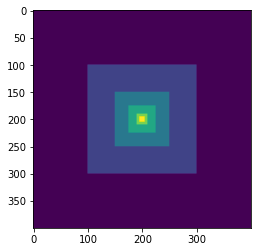

In [6]:
# Lens param
x = -0.05
y = 0.1
phi = 1.
q = 0.5
r_ein = 1.4
slope = 2.1

# Source image
src_image = torch.rand([400,400])*0
src_image[100:300,100:300] += 1
src_image[150:250,150:250] += 1
src_image[175:225,175:225] += 1
src_image[190:210,190:210] += 1
src_image[195:205,195:205] += 1
plt.imshow(src_image.cpu())

<ipython-input-3-6c7c12c26adf>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image_array)


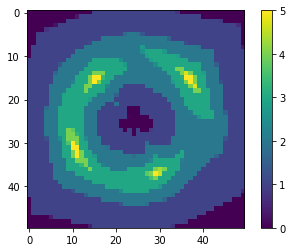

In [7]:
image, coords = image_generator(x, y, phi, q, r_ein*1.05, slope, src_image)
plt.imshow(image.cpu());
plt.colorbar()

In [8]:
def model(v):
    # Lens parameters
    #x = -0.05
    #y = 0.1
    #phi = 1.
    #q = 0.5
    #r_ein = 1.4
    #slope = 2.1
    x, y, phi, q, r_ein, slope = v[:6]
    
    img, _ = image_generator(x, y, phi, q, r_ein, slope, src_image)
    return dict(img = img.cpu())

In [9]:
def noise(sim, v, sigma = SIGMA):
    return dict(img = sim['img'] + np.random.randn(50, 50)*sigma)

In [10]:
low =  np.array([-0.2, -0.2, 0, 0.2, 1.0, 1.5])
high = np.array([0.2, 0.2, 1.5, 0.9, 2.0, 2.5])
prior = swyft.get_uniform_prior(low, high)

In [11]:
sim = swyft.Simulator(model, 6, dict(img=(50,50)))

In [12]:
Ntrain = 2000

store = swyft.Store.memory_store(sim)
store.add(Ntrain, prior)
store.simulate()

Creating new store.
Store: Adding 2055 new samples to simulator store.


<ipython-input-3-6c7c12c26adf>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image_array)


In [13]:
torch.set_default_tensor_type(torch.FloatTensor)  # Needing this is kinda stupid

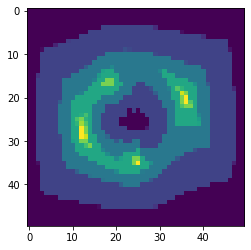

In [14]:
plt.imshow(store[4][0]['img'])

In [15]:
dataset = swyft.Dataset(Ntrain, prior, store, simhook = noise)

In [16]:
class CustomObservationTransform(torch.nn.Module):
    def __init__(self, observation_key: str, observation_shapes: dict):
        super().__init__()
        self.observation_key = observation_key
        self.n_features = 160  # This attribute must be defined!
        
        self.online_z_score = swyft.networks.OnlineDictStandardizingLayer(observation_shapes)
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(10, 20, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(20, 40, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
            torch.nn.Linear(640, 160),
        )

    def forward(self, obs: dict) -> torch.Tensor:
        x = self.online_z_score(obs)
        x = x[self.observation_key]
        x = x.unsqueeze(1)
        x = self.net(x).squeeze(1)
        return x


def get_custom_marginal_classifier(
    observation_transform,
    marginal_indices: tuple,
    n_parameters: int,
    hidden_features: int,
    num_blocks: int,
    marginal_classifier = None,
    parameter_online_z_score: bool = True,
) -> torch.nn.Module:
    n_observation_features = observation_transform.n_features

    parameter_transform = swyft.networks.ParameterTransform(
        n_parameters, marginal_indices, online_z_score=parameter_online_z_score
    )
    n_marginals, n_block_parameters = parameter_transform.marginal_block_shape

    if marginal_classifier is None:
        marginal_classifier = swyft.networks.MarginalClassifier(
            n_marginals,
            n_observation_features + n_block_parameters,
            hidden_features=hidden_features,
            num_blocks=num_blocks,
        )
    else:
        marginal_classifier = marginal_classifier(
            n_marginals,
            n_observation_features + n_block_parameters,
            hidden_features=hidden_features,
            num_blocks=num_blocks,
        )

    return swyft.networks.Network(
        observation_transform,
        parameter_transform,
        marginal_classifier,
    )

In [17]:
marg_indices = tuple([(i,) for i in range(6)])

In [18]:
network_1d = get_custom_marginal_classifier(
    observation_transform=CustomObservationTransform('img', {'img': (50, 50)}),
    marginal_indices=marg_indices,
    n_parameters=6,
    hidden_features=32,
    num_blocks=2,
)

mre_1d = swyft.MarginalRatioEstimator(
    marginal_indices=marg_indices,
    network=network_1d,
    device=DEVICE,
)

In [19]:
vl = mre_1d.train(dataset, batch_size = 64, max_epochs = 100)

/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/torch-1.9.0-py3.8-linux-x86_64.egg/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


training: lr=5e-05, epoch=25, validation loss=3.8915


In [20]:
posterior_1d = swyft.MarginalPosterior(mre_1d, prior)

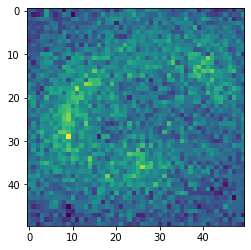

In [21]:
obs0, _, v0 = dataset[3]
samples_1d = posterior_1d.weighted_sample(10000, obs0)
plt.imshow(obs0['img'])

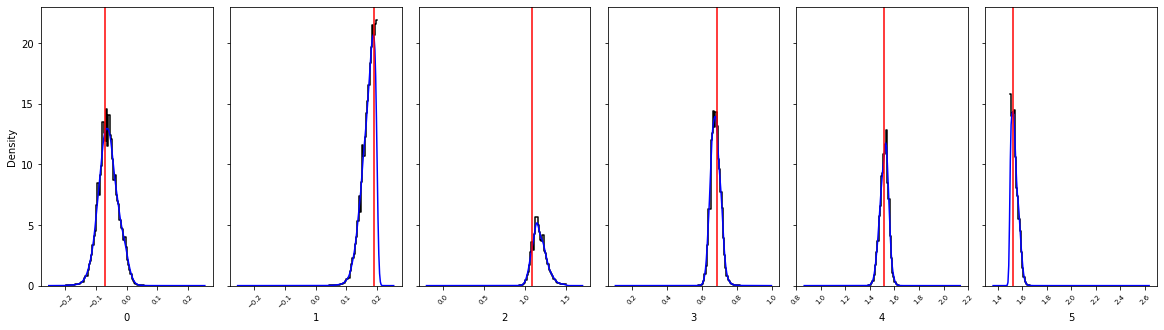

In [22]:
swyft.hist1d(samples_1d, kde = True, figsize = (20, 5), truth = v0);